# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v5/'
figure_dir = os.path.join(paper_dir, 'LassoVsLightGBM')
make_dir_if_not_exists(figure_dir)
os.chdir(paper_dir)

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [2]:
diet_lasso_estimates = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/Lasso/metabolomics_ffq+diet0.05/results.csv', index_col=0)
diet_lgbm_estimates = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_ffq+diet0.05/results.csv', index_col=0)

mb_lasso_estimates = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/Lasso/metabolomics_MB_daphna_LONG5_S_log10/results.csv', index_col=0)
mb_lgbm_estimates = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_MB_daphna_LONG5_S/results.csv', index_col=0)

single_metabs = pd.read_csv('../technical_noise/dataframes/mar17_metabolomics_unnormed_fillna_min_dayfromfirstsample_regressed_rzs.csv', index_col=0)
metabs1 = pd.read_csv('dataframes/metabs1.csv', index_col=0)
pnp_diet_and_ffq = pd.read_csv('dataframes/mar17_ffq+diet0.05.csv', index_col=0)

In [9]:
mb_oos_bs_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/Grouped0.85/Bootstrapping/LightGBM/MB_daphna_LONG5_s/'
mb_oos_bse = pd.read_csv(os.path.join(mb_oos_bs_dir, 'bootstrapping_estimates.csv'), index_col=0).astype(float)
mb_oos = pd.read_csv(os.path.join(mb_oos_bs_dir, 'estimates.csv'), index_col=0).astype(float)

mb_lmm = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/LMMs/Results/technical_noise/MAR17/Metabolomics_grouped/Segata_s/LMM_results.txt', 
                     sep='\t', index_col=0)
mb_lmm['P value'] = mb_lmm['P value'].replace(0, 1e-10)
mb_lmm['q-val'] = fdr_correction(mb_lmm['P value'])[1]
mb_lmm = mb_lmm[mb_lmm['q-val'] < 0.05]
mb_lmm.shape

(317, 9)

# Plot 

0.43239554983856143 0.08350807325969381
0.14989847410374726 0.046425367968271875


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


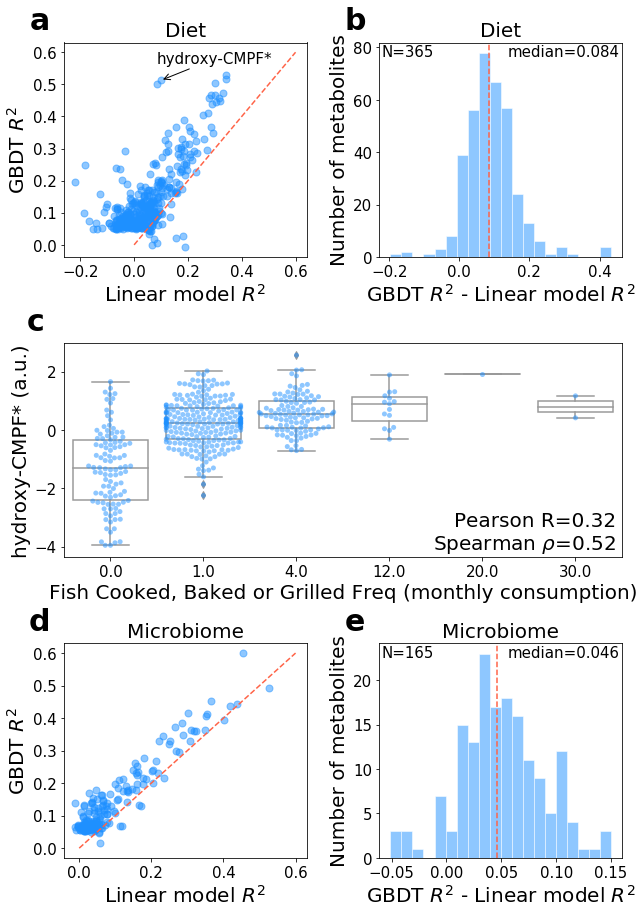

In [7]:
label_size = 20
tick_size = 15
y_label_gbt = 'GBDT $R^2$'
x_label_linear = 'Linear model $R^2$'

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.4)

r2_col = 'Coefficient_of_determination'

lasso_est = diet_lasso_estimates[[r2_col]].rename(columns={r2_col: 'lasso r2'}).copy()
lgbm_est = diet_lgbm_estimates[[r2_col]].rename(columns={r2_col: 'lgbm r2'}).copy()
temp_est = pd.concat((lasso_est, lgbm_est), axis=1)
lower_bound_for_ev = 0.05
temp_est = temp_est[(temp_est['lasso r2'] > lower_bound_for_ev) | (temp_est['lgbm r2'] > lower_bound_for_ev)]
lasso_est = temp_est['lasso r2']
lgbm_est = temp_est['lgbm r2']

# ax = axes[0]
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(lasso_est, lgbm_est, 'o', markersize=7, alpha=0.5, color='dodgerblue')
ax1.plot([0, 0.6], [0, 0.6], '--', color='tomato')

c = '100019794'
ax1.annotate(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] , 
            xy=(lasso_est.loc[c], lgbm_est.loc[c]), 
            xytext=(0.3, 0.58), 
            arrowprops={'arrowstyle':'->',  'color':'black'},
            ha='center', va='center', fontsize=tick_size)

ax1.set_xlabel(x_label_linear, fontsize=label_size)
ax1.set_ylabel(y_label_gbt, fontsize=label_size)
ax1.set_title('Diet', fontsize=label_size)
ax1.tick_params(labelsize=tick_size)

# ax = axes[1]
ax2 = fig.add_subplot(gs[0, 1])
diffs = lgbm_est - lasso_est
median = diffs.median()
print (diffs.max(), diffs.median())
ax2.hist(diffs.dropna(), bins=20, alpha=0.5, color='dodgerblue', ec='white')
ax2.axvline(x=median, linestyle='--', color='tomato')
ax2.set_xlabel(y_label_gbt + ' - ' + x_label_linear, fontsize=label_size)
ax2.set_ylabel('Number of metabolites', fontsize=label_size)
ax2.set_title('Diet', fontsize=label_size)
ax2.tick_params(labelsize=tick_size)
add_text_at_corner(ax2, 'N=%0.1d'%lgbm_est.shape[0], 'top left', fontsize=tick_size)
add_text_at_corner(ax2, 'median=%0.2g'%median, 'top right', fontsize=tick_size)


# ax = axes[2]
ax3 = fig.add_subplot(gs[1, :])
f = 'Fish Cooked, Baked or Grilled Freq'
c = '100019794'
data = pd.concat((pnp_diet_and_ffq[f], 
                  single_metabs[c]), axis=1)
sns.boxplot(data = data,
            x = f, y = c, color='white', ax=ax3)
sns.swarmplot(data = data,
            x = f, y = c, color='dodgerblue', ax=ax3, alpha=0.5)
ax3.tick_params(labelsize=tick_size)
ax3.set_xlabel(f + ' (monthly consumption)', fontsize=label_size)
ax3.set_ylabel(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (a.u.)', fontsize=label_size)
# ax.set_ylabel('hydroxy-CMPF (a.u.)', fontsize=label_size)

r_s, p_s = spearmanr(data[c], data[f], nan_policy='omit')
r_p, p_p = pearsonr_rmna(data[c], data[f])
add_text_at_corner(ax3, 'Pearson R=%0.2g\nSpearman %s=%0.2g'%(r_p, r'$\rho$', r_s), 'bottom right', fontsize=label_size)

lasso_est = mb_lasso_estimates[[r2_col]].rename(columns={r2_col: 'lasso r2'}).copy()
lgbm_est = mb_lgbm_estimates[[r2_col]].rename(columns={r2_col: 'lgbm r2'}).copy()
temp_est = pd.concat((lasso_est, lgbm_est), axis=1)
lower_bound_for_ev = 0.05
temp_est = temp_est[(temp_est['lasso r2'] > lower_bound_for_ev) | (temp_est['lgbm r2'] > lower_bound_for_ev)]
lasso_est = temp_est['lasso r2']
lgbm_est = temp_est['lgbm r2']

ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(lasso_est, lgbm_est, 'o', markersize=7, alpha=0.5, color='dodgerblue')
ax4.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax4.set_xlabel(x_label_linear, fontsize=label_size)
ax4.set_ylabel(y_label_gbt, fontsize=label_size)
ax4.set_title('Microbiome', fontsize=label_size)
ax4.tick_params(labelsize=tick_size)

ax5 = fig.add_subplot(gs[2, 1])
diffs = lgbm_est - lasso_est
median = diffs.median()
print (diffs.max(), diffs.median())
ax5.hist(diffs.dropna(), bins=20, alpha=0.5, color='dodgerblue', ec='white')
ax5.axvline(x=median, linestyle='--', color='tomato')
ax5.set_xlabel(y_label_gbt + ' - ' + x_label_linear, fontsize=label_size)
ax5.set_ylabel('Number of metabolites', fontsize=label_size)
ax5.set_title('Microbiome', fontsize=label_size)
ax5.tick_params(labelsize=tick_size)
add_text_at_corner(ax5, 'N=%0.1d'%lgbm_est.shape[0], 'top left', fontsize=tick_size)
add_text_at_corner(ax5, 'median=%0.2g'%median, 'top right', fontsize=tick_size)

fig.tight_layout()

plt.text(-0.1, 1.1, 'a', ha='center', va='center', transform=ax1.transAxes, fontsize=30, weight='bold') # ,  fontweight='bold'
plt.text(-0.1, 1.1, 'b', ha='center', va='center', transform=ax2.transAxes, fontsize=30, weight='bold')
plt.text(-0.05, 1.1, 'c', ha='center', va='center', transform=ax3.transAxes, fontsize=30, weight='bold')
plt.text(-0.1, 1.1, 'd', ha='center', va='center', transform=ax4.transAxes, fontsize=30, weight='bold')
plt.text(-0.1, 1.1, 'e', ha='center', va='center', transform=ax5.transAxes, fontsize=30, weight='bold')


plt.savefig(os.path.join(figure_dir, 'Supp_A-E_LightGBM_vs_Lasso_predictions_with_example_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'Supp_A-E_LightGBM_vs_Lasso_predictions_with_example.png'), dpi=1200, bbox_inches='tight')

# joined with insample vs out of sample

0.43239554983856143 0.08350807325969381
0.14989847410374726 0.046425367968271875


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


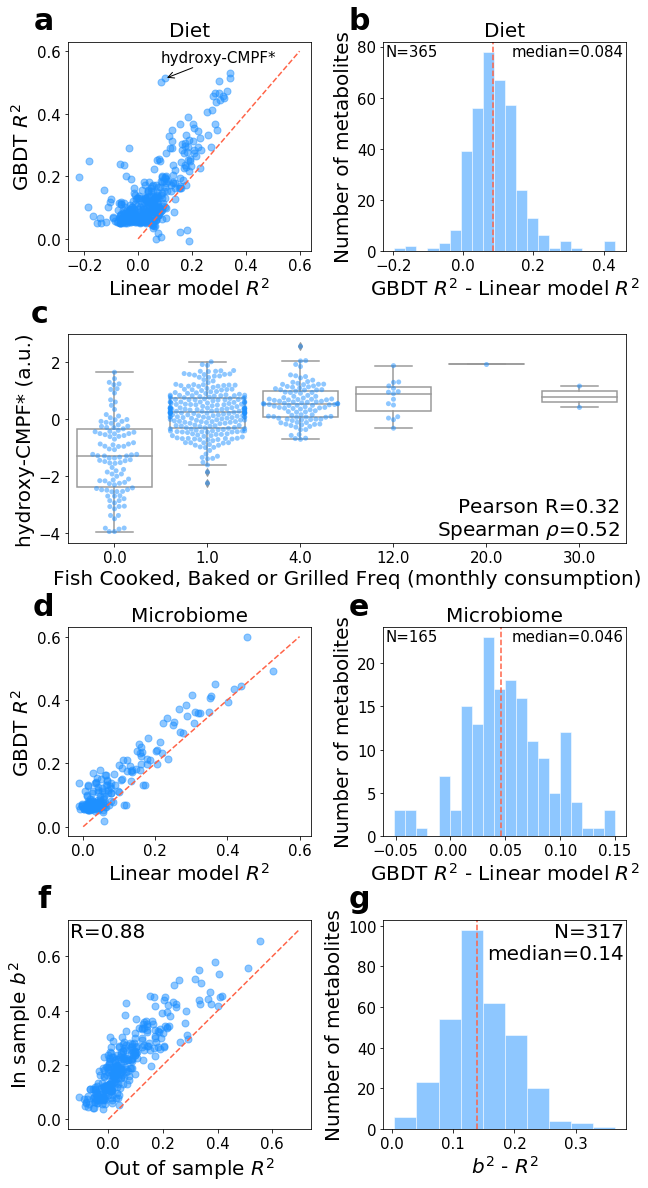

In [11]:
label_size = 20
tick_size = 15
y_label_gbt = 'GBDT $R^2$'
x_label_linear = 'Linear model $R^2$'

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig = plt.figure(figsize=(10, 20))
gs = gridspec.GridSpec(4, 2, wspace=0.3, hspace=0.4)

r2_col = 'Coefficient_of_determination'

lasso_est = diet_lasso_estimates[[r2_col]].rename(columns={r2_col: 'lasso r2'}).copy()
lgbm_est = diet_lgbm_estimates[[r2_col]].rename(columns={r2_col: 'lgbm r2'}).copy()
temp_est = pd.concat((lasso_est, lgbm_est), axis=1)
lower_bound_for_ev = 0.05
temp_est = temp_est[(temp_est['lasso r2'] > lower_bound_for_ev) | (temp_est['lgbm r2'] > lower_bound_for_ev)]
lasso_est = temp_est['lasso r2']
lgbm_est = temp_est['lgbm r2']

# ax = axes[0]
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(lasso_est, lgbm_est, 'o', markersize=7, alpha=0.5, color='dodgerblue')
ax1.plot([0, 0.6], [0, 0.6], '--', color='tomato')

c = '100019794'
ax1.annotate(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] , 
            xy=(lasso_est.loc[c], lgbm_est.loc[c]), 
            xytext=(0.3, 0.58), 
            arrowprops={'arrowstyle':'->',  'color':'black'},
            ha='center', va='center', fontsize=tick_size)

ax1.set_xlabel(x_label_linear, fontsize=label_size)
ax1.set_ylabel(y_label_gbt, fontsize=label_size)
ax1.set_title('Diet', fontsize=label_size)
ax1.tick_params(labelsize=tick_size)

# ax = axes[1]
ax2 = fig.add_subplot(gs[0, 1])
diffs = lgbm_est - lasso_est
median = diffs.median()
print (diffs.max(), diffs.median())
ax2.hist(diffs.dropna(), bins=20, alpha=0.5, color='dodgerblue', ec='white')
ax2.axvline(x=median, linestyle='--', color='tomato')
ax2.set_xlabel(y_label_gbt + ' - ' + x_label_linear, fontsize=label_size)
ax2.set_ylabel('Number of metabolites', fontsize=label_size)
ax2.set_title('Diet', fontsize=label_size)
ax2.tick_params(labelsize=tick_size)
add_text_at_corner(ax2, 'N=%0.1d'%lgbm_est.shape[0], 'top left', fontsize=tick_size)
add_text_at_corner(ax2, 'median=%0.2g'%median, 'top right', fontsize=tick_size)


# ax = axes[2]
ax3 = fig.add_subplot(gs[1, :])
f = 'Fish Cooked, Baked or Grilled Freq'
c = '100019794'
data = pd.concat((pnp_diet_and_ffq[f], 
                  single_metabs[c]), axis=1)
sns.boxplot(data = data,
            x = f, y = c, color='white', ax=ax3)
sns.swarmplot(data = data,
            x = f, y = c, color='dodgerblue', ax=ax3, alpha=0.5)
ax3.tick_params(labelsize=tick_size)
ax3.set_xlabel(f + ' (monthly consumption)', fontsize=label_size)
ax3.set_ylabel(metabs1[metabs1.CHEMICAL_ID == c].BIOCHEMICAL.values[0] + ' (a.u.)', fontsize=label_size)
# ax.set_ylabel('hydroxy-CMPF (a.u.)', fontsize=label_size)

r_s, p_s = spearmanr(data[c], data[f], nan_policy='omit')
r_p, p_p = pearsonr_rmna(data[c], data[f])
add_text_at_corner(ax3, 'Pearson R=%0.2g\nSpearman %s=%0.2g'%(r_p, r'$\rho$', r_s), 'bottom right', fontsize=label_size)

lasso_est = mb_lasso_estimates[[r2_col]].rename(columns={r2_col: 'lasso r2'}).copy()
lgbm_est = mb_lgbm_estimates[[r2_col]].rename(columns={r2_col: 'lgbm r2'}).copy()
temp_est = pd.concat((lasso_est, lgbm_est), axis=1)
lower_bound_for_ev = 0.05
temp_est = temp_est[(temp_est['lasso r2'] > lower_bound_for_ev) | (temp_est['lgbm r2'] > lower_bound_for_ev)]
lasso_est = temp_est['lasso r2']
lgbm_est = temp_est['lgbm r2']

ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(lasso_est, lgbm_est, 'o', markersize=7, alpha=0.5, color='dodgerblue')
ax4.plot([0, 0.6], [0, 0.6], '--', color='tomato')
ax4.set_xlabel(x_label_linear, fontsize=label_size)
ax4.set_ylabel(y_label_gbt, fontsize=label_size)
ax4.set_title('Microbiome', fontsize=label_size)
ax4.tick_params(labelsize=tick_size)

ax5 = fig.add_subplot(gs[2, 1])
diffs = lgbm_est - lasso_est
median = diffs.median()
print (diffs.max(), diffs.median())
ax5.hist(diffs.dropna(), bins=20, alpha=0.5, color='dodgerblue', ec='white')
ax5.axvline(x=median, linestyle='--', color='tomato')
ax5.set_xlabel(y_label_gbt + ' - ' + x_label_linear, fontsize=label_size)
ax5.set_ylabel('Number of metabolites', fontsize=label_size)
ax5.set_title('Microbiome', fontsize=label_size)
ax5.tick_params(labelsize=tick_size)
add_text_at_corner(ax5, 'N=%0.1d'%lgbm_est.shape[0], 'top left', fontsize=tick_size)
add_text_at_corner(ax5, 'median=%0.2g'%median, 'top right', fontsize=tick_size)



temp_est = mb_oos.copy()
r2_col = 'Coefficient_of_determination'
ax6 = fig.add_subplot(gs[3, 0])
ax6.plot(temp_est[r2_col], 
        mb_lmm.reindex(temp_est.index, axis=0)['microbiome-association index'], 
        'o', markersize=7, alpha=0.5, color='dodgerblue')
ax6.plot([0, 0.7], [0, 0.7], '--', color='tomato')
ax6.set_xlabel('Out of sample $R^2$', fontsize=label_size)
ax6.set_ylabel('In sample $b^2$', fontsize=label_size)
ax6.tick_params(labelsize=tick_size)
r, p = pearsonr_rmna(temp_est[r2_col], 
                     mb_lmm.reindex(temp_est.index, axis=0)['microbiome-association index'])
add_text_at_corner(ax6, 'R=%0.2g'%r, 'top left', fontsize=label_size)
ax7 = fig.add_subplot(gs[3, 1])
diffs = mb_lmm.reindex(temp_est.index, axis=0)['microbiome-association index'] - temp_est[r2_col]
median = diffs.median()
ax7.hist(diffs.dropna(), bins=10, color='dodgerblue', alpha=0.5, ec='white')
ax7.axvline(x=median, linestyle='--', color='tomato')
ax7.set_xlabel('$b^2$ - $R^2$', fontsize=label_size)
ax7.set_ylabel('Number of metabolites', fontsize=label_size)
ax7.tick_params(labelsize=tick_size)
add_text_at_corner(ax7, 'N=%0.1d'%mb_lmm.reindex(temp_est.index, axis=0).dropna().shape[0], 'top right', fontsize=label_size)
add_text_at_corner(ax7, '\nmedian=%0.2g'%median, 'top right', fontsize=label_size)


fig.tight_layout()

plt.text(-0.1, 1.1, 'a', ha='center', va='center', transform=ax1.transAxes, fontsize=30, weight='bold') # ,  fontweight='bold'
plt.text(-0.1, 1.1, 'b', ha='center', va='center', transform=ax2.transAxes, fontsize=30, weight='bold')
plt.text(-0.05, 1.1, 'c', ha='center', va='center', transform=ax3.transAxes, fontsize=30, weight='bold')
plt.text(-0.1, 1.1, 'd', ha='center', va='center', transform=ax4.transAxes, fontsize=30, weight='bold')
plt.text(-0.1, 1.1, 'e', ha='center', va='center', transform=ax5.transAxes, fontsize=30, weight='bold')
plt.text(-0.1, 1.1, 'f', ha='center', va='center', transform=ax6.transAxes, fontsize=30, weight='bold')
plt.text(-0.1, 1.1, 'g', ha='center', va='center', transform=ax7.transAxes, fontsize=30, weight='bold')


plt.savefig(os.path.join(paper_dir, 'Supplementary_figure2_LightGBM_vs_Lasso_and_insample_vs_outofsample_small.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(paper_dir, 'Supplementary_figure2_LightGBM_vs_Lasso_and_insample_vs_outofsample.png'), dpi=1200, bbox_inches='tight')